<a href="https://colab.research.google.com/github/avanit-kushwaha/Forensic-Image-to-Sketch-Using-GAN/blob/main/Major_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import os
import numpy as np
import glob
from PIL import Image

In [ ]:
def transform_image(img, skt, ang_range, shear_range, trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    # Border
    idx = 0
    border_img = tuple([int(img[idx][0][0]), int(img[idx][0][1]), int(img[idx][0][2])])
    border_skt = tuple([int(skt[0][0][0]), int(skt[0][0][1]), int(skt[0][0][2])])

    img = cv2.warpAffine(img,Rot_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,Trans_M,(cols,rows), borderValue=border_img)
    img = cv2.warpAffine(img,shear_M,(cols,rows), borderValue=border_img)

    skt = cv2.warpAffine(skt,Rot_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,Trans_M,(cols,rows), borderValue=border_skt)
    skt = cv2.warpAffine(skt,shear_M,(cols,rows), borderValue=border_skt)

    return img, skt

In [ ]:
# sketch_dir = '/content/gdrive/MyDrive/F-to-S/Dataset/New_Augmented_sketch/'
# photo_dir = '/content/gdrive/MyDrive/F-to-S/Dataset/New_Augmented_photo/'

# if not os.path.exists(sketch_dir):
#     os.mkdir(sketch_dir)

# if not os.path.exists(photo_dir):
#     os.mkdir(photo_dir)

# p_filenames = glob.glob('/content/gdrive/MyDrive/F-to-S/Dataset/Training photo/*')
# s_filenames = glob.glob('/content/gdrive/MyDrive/F-to-S/Dataset/Training sketch/*')

# counter = 0
# for i in range(len(p_filenames)):
#     im = cv2.imread(p_filenames[i])
#     sk = cv2.imread(s_filenames[i])

#     for j in range(200):
#         img, skt = transform_image(im, sk, 40, 10, 10)

#         cv2.imwrite(photo_dir + str(counter) + '.jpg', img)
#         cv2.imwrite(sketch_dir + str(counter) + '.jpg', skt)

#         counter += 1

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!git clone https://www.github.com/keras-team/keras-contrib.git

fatal: destination path 'keras-contrib' already exists and is not an empty directory.


In [ ]:
%cd keras-contrib
!python setup.py install

/content/keras-contrib
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
        standards-based to

In [ ]:
import keras_contrib

In [ ]:
!pip install natsort

In [ ]:
from __future__ import print_function, division

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, BatchNormalization, Activation, ZeroPadding2D
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import LeakyReLU
# from keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.layers import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

#from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import datetime
import natsort
import scipy
import sys
import os
import cv2

In [ ]:
from random import shuffle
import natsort
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy
import sys
import os
import cv2

In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

# load all images in a directory into memory
def load_images(list_path, size=(256, 256)):
    img_list = list()
    # enumerate filenames in directory, assume all are images
    for filename in list_path:
        # load and resize the image
        pixels = load_img(filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        pixels = (pixels - 127.5) / 127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset

    # choose random instances
    ix = np.random.randint(0, trainA.shape[0], n_samples)

    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]

    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))

    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)

    # create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape, patch_shape, 1))

    return X, y

In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, d_model, dataset, target_dir='', n_samples=3):
    if target_dir and not os.path.exists(target_dir):
        os.mkdir(target_dir)
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(target_dir + filename1)
    plt.close()
    # save the generator model
    g_model.save(target_dir + 'g_model.h5')

    # save the discriminator model
    d_model.save(target_dir + 'd_model.h5')

    print('>Saved: %s and %s' % (filename1, 'g_model & d_model'))


In [ ]:
def generator(img_shape):
    def conv2d(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    def deconv2d(layer_in, skip_in, n_filter, dropout=0.5):
        d = UpSampling2D(size=2)(layer_in)
        d = Conv2D(n_filter, kernel_size=4, strides=1, padding='same', activation='relu')(d)
        if dropout:
            d = Dropout(dropout)(d)
        d = InstanceNormalization()(d)
        d = Concatenate()([d, skip_in])
        return d

    # Input Layer
    in_img = Input(shape=img_shape)

    # Downsampling
    d1 = conv2d(in_img, 64, norm=False)
    d2 = conv2d(d1, 128)
    d3 = conv2d(d2, 256)
    d4 = conv2d(d3, 512)
    d5 = conv2d(d4, 512)
    d6 = conv2d(d5, 512)
    d7 = conv2d(d6, 512)

    # Upsampling
    u1 = deconv2d(d7, d6, 512)
    u2 = deconv2d(u1, d5, 512)
    u3 = deconv2d(u2, d4, 512)
    u4 = deconv2d(u3, d3, 256, dropout=0)
    u5 = deconv2d(u4, d2, 128, dropout=0)
    u6 = deconv2d(u5, d1, 64, dropout=0)
    u7 = UpSampling2D(size=2)(u6)

    out_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

    return Model(in_img, out_img, name='generator')

In [ ]:
def discriminator(img_shape):
    def d_layer(layer_in, n_filter, norm=True):
        d = Conv2D(n_filter, kernel_size=4, strides=2, padding='same')(layer_in)
        d = LeakyReLU(0.2)(d)
        if norm:
            d = InstanceNormalization()(d)
        return d

    in_src_img = Input(shape=img_shape)
    in_target_img = Input(shape=img_shape)

    merged = Concatenate()([in_src_img, in_target_img])

    d1 = d_layer(merged, 64, norm=False)
    d2 = d_layer(d1, 128)
    d3 = d_layer(d1, 256)
    d4 = d_layer(d1, 512)

    out = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

    return Model([in_src_img, in_target_img], out, name='discriminator')

In [ ]:
def GAN(g_model, d_model, img_shape):
    d_model.trainable = False
    in_img = Input(shape=img_shape)
    gen_out = g_model(in_img)
    dis_out = d_model([in_img, gen_out])
    model = Model(in_img, [dis_out, gen_out], name='GAN')
    return model

In [ ]:
def train(d_model, g_model, gan_model, data, target_dir, n_epochs=100, n_batch=16):


    if any(element is None for element in data):
      raise ValueError("Data elements cannot be None. Check data loading process.")


    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]

    blue_photo = data[0]
    blue_sketch = data[1]
    # print(type(blue_photo), type(blue_sketch))

    for i in range(n_epochs):
        print(' ========== Epoch', i+1, '========== ')

        print("check 1")
        #print(blue_sketch)
        #x = shuffle([1,2,3,4,5,6],2)
        #print(x)
        shuffle(blue_photo)
        shuffle(blue_sketch)

        print("check 1.5")
        for j in range(int(len(blue_photo)/n_batch)):

            start = int(j*n_batch)
            end = int(min(len(blue_photo), (j*n_batch)+n_batch))

            print("check 2")
            dataset = [load_images(blue_photo[start:end]), load_images(blue_sketch[start:end])]

            print("check 3")
            # select a batch of real samples
            [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)

            print("check 4")
            # generate a batch of fake samples
            X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)

            print("check 5")
            # update discriminator for real samples
            d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)

            print("check 6")
            # update discriminator for generated samples
            d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)

            print("check 7")

            d_loss = 0.5 * np.add(d_loss1, d_loss2)

            print("check 8", gan_model.train_on_batch(X_realA, [y_real, X_realB]))

            # update the generator
            g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])

            print("check 9")

            # summarize performance
            print('Batch : %d, D Loss : %.3f | G Loss : %.3f' % (j+1, d_loss, g_loss))

            print("check 10")
        # summarize model performance
#         if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, target_dir)

In [ ]:
import tensorflow as tf
import keras.backend as K
from keras.losses import mean_absolute_error

def pixel_loss(y_true, y_pred):
    return K.mean(K.abs(y_true - y_pred))

def contextual_loss (y_true, y_pred):
    a = tf.image.rgb_to_grayscale(tf.slice(
                                y_pred,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    b = tf.image.rgb_to_grayscale(tf.slice(
                                y_true,
                                [0,0,0,0],
                                [16, 256, 256, 3]))

    y_pred = tf.divide(tf.add(tf.reshape(a, [tf.shape(a)[0], -1]), 1), 2)
    y_true = tf.divide(tf.add(tf.reshape(b, [tf.shape(b)[0], -1]), 1), 2)

#     tf.assert_rank(y_true,2)
#     tf.assert_rank(y_pred,2)

    p_shape = tf.shape(y_true)
    q_shape = tf.shape(y_pred)
#     tf.assert_equal(p_shape, q_shape)

    # normalize sum to 1
    p_ = tf.divide(y_true, tf.tile(tf.expand_dims(tf.reduce_sum(y_true, axis=1), 1), [1,p_shape[1]]))
    q_ = tf.divide(y_pred, tf.tile(tf.expand_dims(tf.reduce_sum(y_pred, axis=1), 1), [1,p_shape[1]]))

    return tf.reduce_sum(tf.multiply(p_, tf.math.log(tf.divide(p_, q_))), axis=1)

def total_loss (y_true, y_pred):

    px_loss = pixel_loss(y_true, y_pred)

    ctx_loss = contextual_loss(y_true, y_pred)

    return (0.2 * px_loss) + (0.8 * ctx_loss)


In [ ]:
# # dataset path
# b_photo_path = '/content/gdrive/MyDrive/F-to-S/Dataset/Augmented_photo'
# b_sketch_path = '/content/gdrive/MyDrive/F-to-S/Dataset/Augmented_sketch'

# blue_photo = load_filenames(b_photo_path)
# blue_sketch = load_filenames(b_sketch_path)

In [ ]:
!pip install natsort

In [ ]:
import natsort

def load_filenames(directory):
    dir_files = os.listdir(directory)
    for i, file in enumerate(dir_files):
        dir_files[i] = os.path.join(directory, file)
    return natsort.natsorted(dir_files, reverse=False)

In [ ]:
# dataset path
b_photo_path = '/content/gdrive/MyDrive/content/n2/newTwo/celeb'
b_sketch_path = '/content/gdrive/MyDrive/content/n2/newTwo/celeb_sketch'

blue_photo = load_filenames(b_photo_path)
blue_sketch = load_filenames(b_sketch_path)

In [ ]:
# img = cv2.imread(blue_photo[1102])
# if img is not None:
#     # Perform operations on the image
#     plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[1102]).astype('uint8'), cv2.COLOR_BGR2RGB))
# else:
#     print("Failed to load image:", blue_photo[1102])


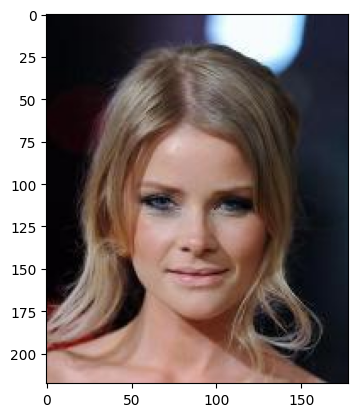

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_photo[9]).astype('uint8'), cv2.COLOR_BGR2RGB))

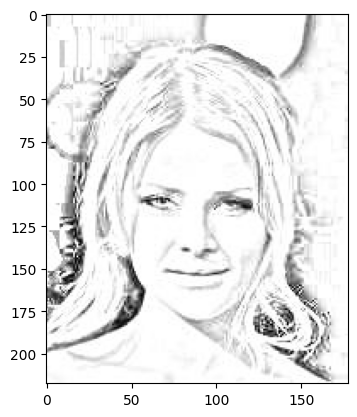

In [ ]:
plt.imshow(cv2.cvtColor(cv2.imread(blue_sketch[9]).astype('uint8'), cv2.COLOR_BGR2RGB))

In [ ]:
!pip install tensorflow==2.15.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
!pip install tensorflow-addons


In [ ]:
from tensorflow_addons.layers import InstanceNormalization


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
img_shape = (256, 256, 3)

d_model = discriminator(img_shape)

g_model = generator(img_shape)

gan_model = GAN(g_model, d_model, img_shape)

In [ ]:
# gan_model.summary()

In [ ]:
opt = Adam(lr=2e-4, beta_1=0.5)

d_model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
gan_model.compile(loss=['binary_crossentropy', total_loss], optimizer=opt, loss_weights=[1,100])

In [ ]:
import tensorflow as tf

In [ ]:
def flatten_metrics_in_order(logs, metrics_names):
    if logs is not None:
        results = []
        for name in metrics_names:
            if name in logs:
                results.append(logs[name])
        for key in sorted(logs.keys()):
            if key not in metrics_names:
                results.append(logs[key])
        return results
    else:
        return []



In [ ]:
os.mkdir('/content/Models')

In [ ]:
os.mkdir('/content/Models/Pixel[02]_Context[08]/')

In [ ]:
# os.mkdir('/content/gdrive/MyDrive/Models/')

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
# from PIL import Image
# import numpy as np

# def load_image(file_path, target_size):
#     img = Image.open(file_path)
#     img = img.resize(target_size)
#     return np.array(img)

# # Example usage:
# image = load_image("path_to_image.jpg", (width, height))

generator=[41.438,33.167,30.440,30.440,46.808,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,]

dis=[2.491, 2.448,2.468,2.468,2.288,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,555,]

In [ ]:
train(d_model, g_model, gan_model, [blue_sketch, blue_photo], '/content/gdrive/MyDrive/Models/', n_epochs = 8, n_batch=16)


 ========== Epoch 1 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 29ms/step
check 5
check 6
check 7
check 8 [43.63346862792969, 6.03038215637207, 0.3760308623313904]
check 9
Batch : 1, D Loss : 2.491 | G Loss : 41.438
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 44ms/step
check 5
check 6
check 7
check 8 [33.98530578613281, 5.70431661605835, 0.28280988335609436]
check 9
Batch : 2, D Loss : 2.448 | G Loss : 33.167
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [32.15849685668945, 6.140698432922363, 0.26017796993255615]
check 9
Batch : 3, D Loss : 2.468 | G Loss : 30.440
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 27ms/step
check 5
check 6
check 7
check 8 [48.973243713378906, 6.007116794586182, 0.42966124415397644]
check 9
Batch : 4, D Loss : 2.288 | G Loss : 46.808
check 10
check 2
check 3
check 4
1/1 [=======

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


>Saved: plot_000001.png and g_model & d_model
 ========== Epoch 2 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 30ms/step
check 5
check 6
check 7
check 8 [33.72784423828125, 6.200707912445068, 0.27527135610580444]
check 9
Batch : 1, D Loss : 2.454 | G Loss : 36.194
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [35.71546173095703, 6.840685844421387, 0.28874775767326355]
check 9
Batch : 2, D Loss : 2.499 | G Loss : 34.304
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [51.238525390625, 6.1165924072265625, 0.4512193202972412]
check 9
Batch : 3, D Loss : 2.389 | G Loss : 47.359
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 27ms/step
check 5
check 6
check 7
check 8 [32.08295440673828, 6.183304786682129, 0.25899648666381836]
check 9
Batch : 4, D Loss : 2.507 | G Loss : 30.272

>Saved: plot_000002.png and g_model & d_model
 ========== Epoch 3 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 58ms/step
check 5
check 6
check 7
check 8 [34.06161117553711, 5.55607271194458, 0.28505539894104004]
check 9
Batch : 1, D Loss : 2.369 | G Loss : 33.207
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 29ms/step
check 5
check 6
check 7
check 8 [27.89949607849121, 5.270416736602783, 0.22629079222679138]
check 9
Batch : 2, D Loss : 2.426 | G Loss : 26.756
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 28ms/step
check 5
check 6
check 7
check 8 [29.918556213378906, 5.301054000854492, 0.24617502093315125]
check 9
Batch : 3, D Loss : 2.362 | G Loss : 27.271
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 33ms/step
check 5
check 6
check 7
check 8 [24.436962127685547, 5.138644218444824, 0.19298316538333893]
check 9
Batch : 4, D Loss : 2.459 | G Loss : 23.

>Saved: plot_000003.png and g_model & d_model
 ========== Epoch 4 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 30ms/step
check 5
check 6
check 7
check 8 [33.83769226074219, 5.388210296630859, 0.2844948172569275]
check 9
Batch : 1, D Loss : 2.449 | G Loss : 33.102
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 31ms/step
check 5
check 6
check 7
check 8 [37.506927490234375, 6.804532527923584, 0.30702394247055054]
check 9
Batch : 2, D Loss : 2.397 | G Loss : 36.800
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [35.99563217163086, 6.631433486938477, 0.29364198446273804]
check 9
Batch : 3, D Loss : 2.385 | G Loss : 33.344
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 42ms/step
check 5
check 6
check 7
check 8 [33.532310485839844, 6.8137664794921875, 0.2671854496002197]
check 9
Batch : 4, D Loss : 2.516 | G Loss : 32.

>Saved: plot_000004.png and g_model & d_model
 ========== Epoch 5 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [34.21989822387695, 6.37028169631958, 0.2784961462020874]
check 9
Batch : 1, D Loss : 2.531 | G Loss : 32.623
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 31ms/step
check 5
check 6
check 7
check 8 [38.20266342163086, 5.911101341247559, 0.32291561365127563]
check 9
Batch : 2, D Loss : 2.514 | G Loss : 36.737
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 52ms/step
check 5
check 6
check 7
check 8 [33.54081344604492, 7.309466361999512, 0.26231345534324646]
check 9
Batch : 3, D Loss : 2.511 | G Loss : 32.023
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 29ms/step
check 5
check 6
check 7
check 8 [31.095260620117188, 6.685912132263184, 0.24409349262714386]
check 9
Batch : 4, D Loss : 2.535 | G Loss : 29.84

>Saved: plot_000005.png and g_model & d_model
 ========== Epoch 6 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 28ms/step
check 5
check 6
check 7
check 8 [26.459606170654297, 6.741006374359131, 0.19718599319458008]
check 9
Batch : 1, D Loss : 2.550 | G Loss : 25.428
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 34ms/step
check 5
check 6
check 7
check 8 [36.989498138427734, 6.136327743530273, 0.3085317015647888]
check 9
Batch : 2, D Loss : 2.515 | G Loss : 35.958
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 26ms/step
check 5
check 6
check 7
check 8 [33.843143463134766, 6.066675186157227, 0.2777646780014038]
check 9
Batch : 3, D Loss : 2.451 | G Loss : 36.155
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 60ms/step
check 5
check 6
check 7
check 8 [35.83507537841797, 6.796003341674805, 0.2903907299041748]
check 9
Batch : 4, D Loss : 2.365 | G Loss : 33.8

>Saved: plot_000006.png and g_model & d_model
 ========== Epoch 7 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 39ms/step
check 5
check 6
check 7
check 8 [33.776485443115234, 6.195446014404297, 0.2758103907108307]
check 9
Batch : 1, D Loss : 2.434 | G Loss : 33.143
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 28ms/step
check 5
check 6
check 7
check 8 [42.26924133300781, 6.251985549926758, 0.3601725399494171]
check 9
Batch : 2, D Loss : 2.442 | G Loss : 41.578
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 42ms/step
check 5
check 6
check 7
check 8 [30.343406677246094, 5.898123741149902, 0.2444528341293335]
check 9
Batch : 3, D Loss : 2.451 | G Loss : 29.080
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 30ms/step
check 5
check 6
check 7
check 8 [32.94206619262695, 5.4074907302856445, 0.27534574270248413]
check 9
Batch : 4, D Loss : 2.416 | G Loss : 32.6

>Saved: plot_000007.png and g_model & d_model
 ========== Epoch 8 ========== 
check 1
check 1.5
check 2
check 3
check 4
1/1 [==============================] - 0s 56ms/step
check 5
check 6
check 7
check 8 [47.7362060546875, 5.878622055053711, 0.41857582330703735]
check 9
Batch : 1, D Loss : 2.348 | G Loss : 45.808
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 32ms/step
check 5
check 6
check 7
check 8 [33.32194900512695, 5.706254005432129, 0.2761569321155548]
check 9
Batch : 2, D Loss : 2.366 | G Loss : 32.947
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 33ms/step
check 5
check 6
check 7
check 8 [29.847320556640625, 5.843975067138672, 0.24003346264362335]
check 9
Batch : 3, D Loss : 2.355 | G Loss : 28.758
check 10
check 2
check 3
check 4
1/1 [==============================] - 0s 28ms/step
check 5
check 6
check 7
check 8 [40.0330810546875, 5.554510116577148, 0.3447856903076172]
check 9
Batch : 4, D Loss : 2.364 | G Loss : 39.148


>Saved: plot_000008.png and g_model & d_model


In [ ]:
g_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
from skimage.metrics import structural_similarity
import numpy as np
import natsort
import os
import cv2

In [ ]:
def load_filename(path):
    dirFiles = os.listdir(path)
    for i, file in enumerate(dirFiles):
        dirFiles[i] = path + file
    return natsort.natsorted(dirFiles ,reverse=False)

def load_images(list_path):
    img_list = list()
    for filename in list_path:
        pixels = cv2.imread(filename)
        img_list.append(pixels)
    return np.asarray(img_list)

In [ ]:
def compute_l2(imgs1, imgs2):
    l2_scores = []
    for i in range(len(imgs1)):
        score = (np.square(imgs1[i] - imgs2[i])).mean()
        l2_scores.append(score)
    return np.mean(l2_scores)

def compute_ssim(imgs1, imgs2):
    ssim_scores = []
    for i in range(len(imgs1)):
        grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
        grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
        (score, diff) = structural_similarity(grayA, grayB, full=True)
        ssim_scores.append(score)
    return np.mean(score)

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from skimage.metrics import structural_similarity as ssim

# Load filenames
def load_filename(directory):
    """
    Get a list of all file paths in a directory ending with '.jpg'.
    """
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg')]

# Load images
def load_images(file_path):
    """
    Load an image from a given file path and resize it to (256, 256).
    """
    return load_img(file_path, target_size=(256, 256))

# Preprocess image
def preprocess_image(img):
    """
    Preprocesses an image by converting it to an array and normalizing to [0, 1].
    """
    img = img_to_array(img).astype('float32') / 255.0
    return img

# Compute L2 norm
def compute_l2(img1, img2):
    """
    Compute the L2 norm between two images.
    """
    return np.linalg.norm(img1 - img2)

# Compute SSIM
def compute_ssim(img1, img2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    """
    img1 = img1.squeeze()  # Remove unnecessary dimensions
    img2 = img2.squeeze()
    return ssim(img1, img2, multichannel=True)

# Paths
imgs1 = preprocess_image(load_images("/content/gdrive/MyDrive/content/new_image/003629.jpg"))
imgs2_list = load_filename("/content/gdrive/MyDrive/content/generated_images")
imgs2 = np.array([preprocess_image(load_images(fp)) for fp in imgs2_list])

# Calculate metrics
l2_values = [compute_l2(imgs1, img2) for img2 in imgs2]
ssim_values = [compute_ssim(imgs1, img2) for img2 in imgs2]

# Print metrics
for i, (l2, ssim_value) in enumerate(zip(l2_values, ssim_values)):
    print(f"Image {i+1}: L2-norm: {l2} :: SSIM: {ssim_value}")


In [ ]:
from PIL import Image
import os

# Define the folder where images will be saved
output_folder = "/content/gdrive/MyDrive/content/generated_images"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Save each image in imgs2
for i, img in enumerate(imgs2):
    # Convert the image back to [0, 255] and uint8
    img_uint8 = (img * 255).astype('uint8')
    # Convert to PIL image and save
    img_pil = Image.fromarray(img_uint8)
    img_pil.save(os.path.join(output_folder, f"generated_image_{i+1}.png"))

print(f"Generated images saved in: {output_folder}")



Generated images saved in: /content/gdrive/MyDrive/content/generated_images


In [ ]:
# from skimage.metrics import structural_similarity as ssim
# import numpy as np
# import natsort
# import os
# import cv2

# def load_filename(path):
#     dirFiles = os.listdir(path)
#     for i, file in enumerate(dirFiles):
#         dirFiles[i] = path + file
#     return natsort.natsorted(dirFiles, reverse=False)

# def load_images(list_path):
#     img_list = list()
#     for filename in list_path:
#         pixels = cv2.imread(filename)
#         img_list.append(pixels)
#     return np.asarray(img_list)

# def compute_msssim(imgs1, imgs2):
#     msssim_scores = []
#     for i in range(len(imgs1)):
#         grayA = cv2.cvtColor(imgs1[i], cv2.COLOR_BGR2GRAY)
#         grayB = cv2.cvtColor(imgs2[i], cv2.COLOR_BGR2GRAY)
#         msssim_score = ssim(grayA, grayB, multichannel=False)
#         msssim_scores.append(msssim_score)
#     return np.mean(msssim_scores)

# imgs1 = load_images(load_filename("/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_photos/"))
# imgs2 = load_images(load_filename("/content/gdrive/MyDrive/S_to_F/generated_images/"))

# msssim = compute_msssim(imgs1, imgs2)

# print("MS-SSIM:", msssim)


In [ ]:
# from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import load_img
# from keras.models import load_model
# import matplotlib.pyplot as plt
# import numpy as np
# import cv2

In [ ]:
# # Load Model
# g_model = load_model('/content/gdrive/MyDrive/Models/g_model.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

# # load and resize the image
# img = load_img('/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_sketches/m1-001-01-sz1.jpg', target_size=(256, 256))
# target = cv2.cvtColor(cv2.imread('/content/gdrive/MyDrive/CUHK_data/CUHK_testing_cropped_photos/m1-001-01.jpg'), cv2.COLOR_BGR2RGB)

# # convert to numpy array
# img = img_to_array(img)
# norm_img = (img.copy() - 127.5) / 127.5

# g_img = g_model.predict(np.expand_dims(norm_img, 0))[0]
# g_img = g_img * 127.5 + 127.5

# img = cv2.resize(img, (200, 250))
# g_img = cv2.resize(g_img, (200, 250))

# f = plt.figure(num=None, figsize=(12, 6), dpi=80)
# ax1 = f.add_subplot(1,3, 1)
# plt.imshow(img.astype('uint8'))
# ax2 = f.add_subplot(1,3, 2)
# plt.imshow(g_img.astype('uint8'))
# ax3 = f.add_subplot(1,3, 3)
# plt.imshow(target.astype('uint8'))
# ax1.set_title('Sketch')
# ax2.set_title('Generated Image')
# ax3.set_title('Target Image')

# plt.show(block=True)

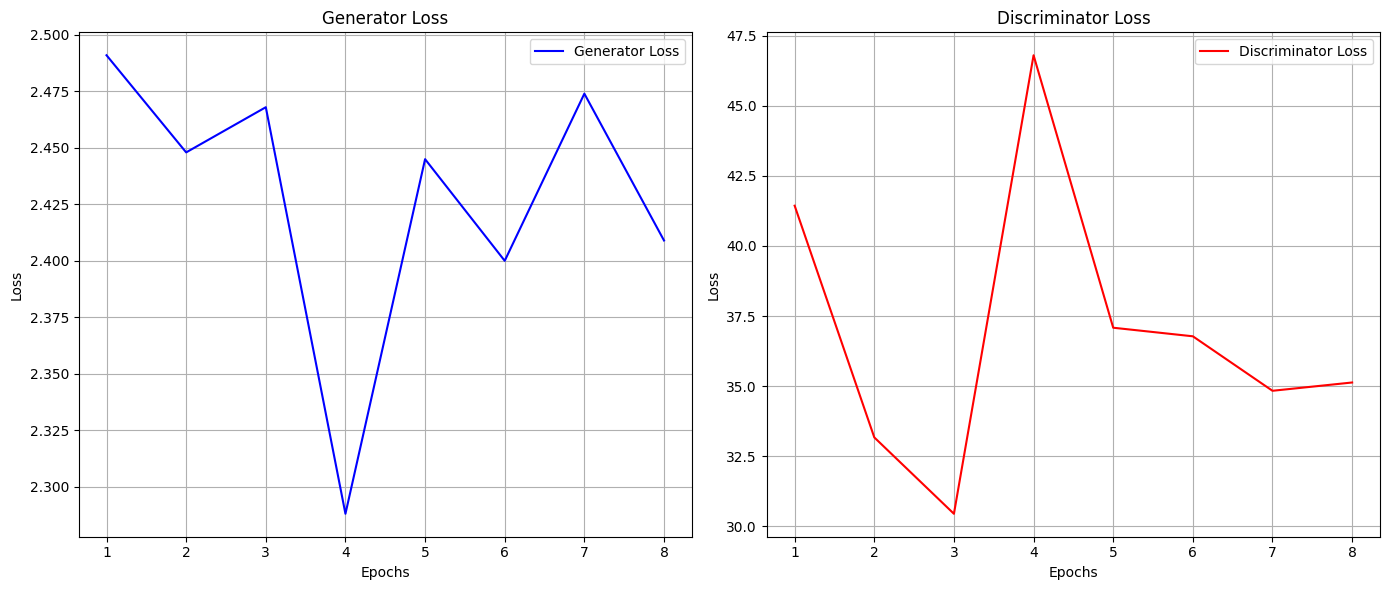

In [ ]:
import matplotlib.pyplot as plt

# Example lists storing loss values for each epoch or batch
generator_loss = [2.491, 2.448, 2.468, 2.288, 2.445, 2.400, 2.474, 2.409]  # Actual training data
discriminator_loss = [41.438, 33.167, 30.440, 46.808, 37.082, 36.776, 34.831, 35.127]  # Actual training data

epochs = range(1, len(generator_loss) + 1)

# Create subplots for the two graphs
plt.figure(figsize=(14, 6))

# Subplot for Generator Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, generator_loss, label='Generator Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.grid(True)
plt.legend()

# Subplot for Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, discriminator_loss, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


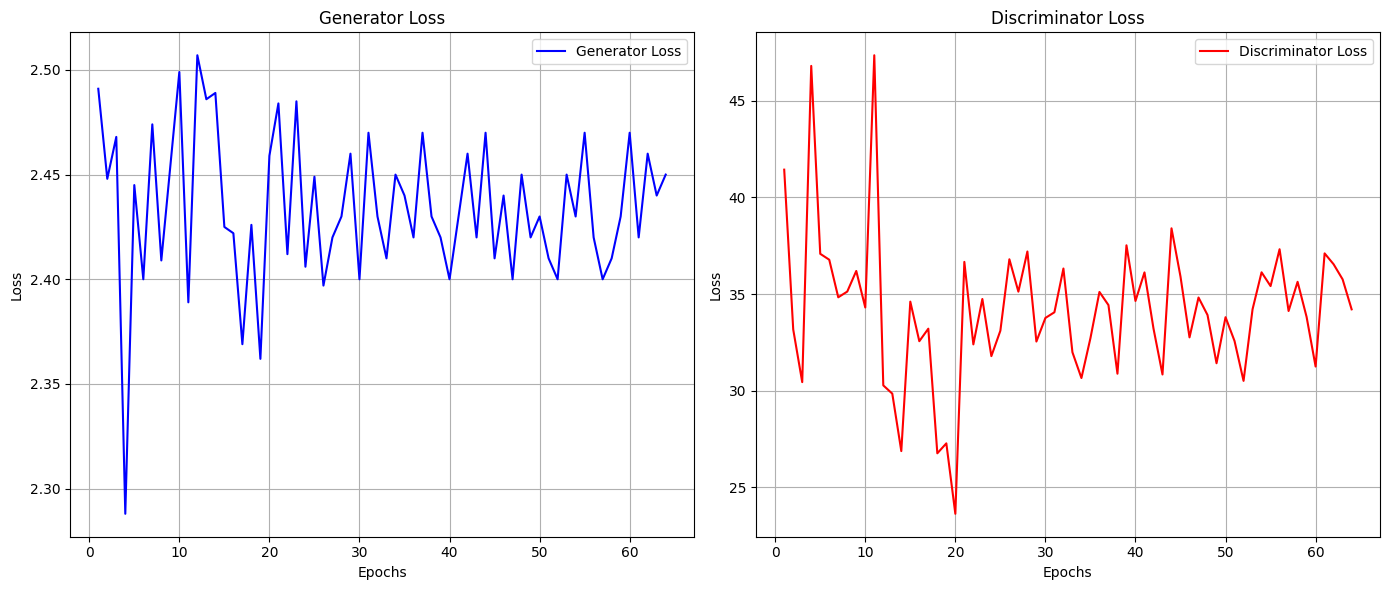

In [ ]:
import matplotlib.pyplot as plt

# Example lists storing loss values for each epoch or batch
generator_loss = [2.491, 2.448, 2.468, 2.288, 2.445, 2.400, 2.474, 2.409,
                   2.454, 2.499, 2.389, 2.507, 2.486, 2.489, 2.425, 2.422,
                  2.369, 2.426, 2.362, 2.459, 2.484, 2.412, 2.485, 2.406,

                  2.449, 2.397, 2.420, 2.430, 2.460, 2.400, 2.470, 2.430,

                   2.410, 2.450, 2.440, 2.420, 2.470, 2.430, 2.420, 2.400,

                   2.430, 2.460, 2.420, 2.470, 2.410, 2.440, 2.400, 2.450,

                   2.420, 2.430, 2.410, 2.400, 2.450, 2.430, 2.470, 2.420,
                   2.400, 2.410, 2.430, 2.470, 2.420, 2.460, 2.440, 2.450]  # Actual training data

discriminator_loss = [41.438, 33.167, 30.440, 46.808, 37.082, 36.776, 34.831, 35.127,

                    36.194, 34.304, 47.359, 30.272, 29.844, 26.871, 34.606, 32.558,

                     33.207, 26.756, 27.271, 23.625, 36.664, 32.394, 34.744, 31.786,

                    33.102, 36.800, 35.123, 37.201, 32.541, 33.762, 34.056, 36.320,

                    31.987, 30.653, 32.716, 35.107, 34.429, 30.876, 37.522, 34.641,

                    36.120, 33.217, 30.836, 38.401, 35.901, 32.756, 34.820, 33.914,

                    31.417, 33.801, 32.567, 30.504, 34.211, 36.124, 35.412, 37.320,

                    34.121, 35.632, 33.815, 31.247, 37.104, 36.541, 35.760, 34.208]  # Actual training data

epochs = range(1, len(generator_loss) + 1)

# Create subplots for the two graphs
plt.figure(figsize=(14, 6))

# Subplot for Generator Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, generator_loss, label='Generator Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.grid(True)
plt.legend()

# Subplot for Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, discriminator_loss, label='Discriminator Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
!pip install pytorch-msssim


In [ ]:
import torch
from pytorch_msssim import ssim, ms_ssim
from skimage import io

# Function to calculate MS-SSIM
def calculate_ms_ssim(img1, img2):
    # Convert images to tensors and ensure they are in the range [0, 1]
    img1 = torch.tensor(img1).permute(2, 0, 1).unsqueeze(0).float()  # [Batch, Channel, Height, Width]
    img2 = torch.tensor(img2).permute(2, 0, 1).unsqueeze(0).float()

    # Calculate MS-SSIM
    ms_ssim_value = ms_ssim(img1, img2, data_range=1.0)  # Assuming the images are normalized to [0, 1]
    return ms_ssim_value.item()

# Load two images
image1 = io.imread('/content/gdrive/MyDrive/project_1024/model_1024plot_000001.png') / 255.0  # Normalize to [0, 1]
image2 = io.imread('/content/gdrive/MyDrive/project_1024/model_1024plot_000002.png') / 255.0  # Normalize to [0, 1]

# Compute MS-SSIM
ms_ssim_result = calculate_ms_ssim(image1, image2)
print("MS-SSIM:", ms_ssim_result)


MS-SSIM: 0.7362912893295288


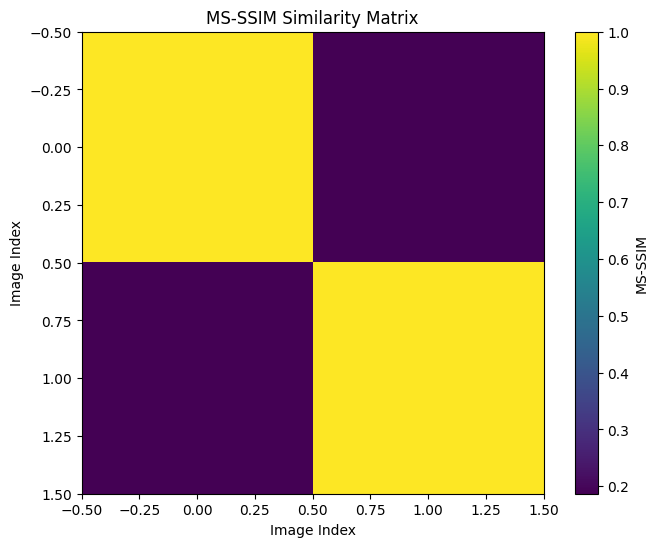

In [ ]:
import torch
from pytorch_msssim import ms_ssim
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate MS-SSIM for two images
def calculate_ms_ssim(img1, img2):
    # Convert images to tensors and ensure they are in the range [0, 1]
    img1 = torch.tensor(img1).permute(2, 0, 1).unsqueeze(0).float()  # [Batch, Channel, Height, Width]
    img2 = torch.tensor(img2).permute(2, 0, 1).unsqueeze(0).float()

    # Calculate MS-SSIM
    ms_ssim_value = ms_ssim(img1, img2, data_range=1.0)  # Assuming the images are normalized to [0, 1]
    return ms_ssim_value.item()

# Function to compute a similarity matrix for a batch of images
def compute_similarity_matrix(images):
    n = len(images)
    matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                matrix[i, j] = 1.0  # MS-SSIM with itself is always 1
            elif j > i:
                matrix[i, j] = calculate_ms_ssim(images[i], images[j])
                matrix[j, i] = matrix[i, j]  # Symmetric matrix

    return matrix

# Visualize similarity matrix as a heatmap
def plot_similarity_matrix(matrix, title="MS-SSIM Similarity Matrix"):
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='MS-SSIM')
    plt.title(title)
    plt.xlabel('Image Index')
    plt.ylabel('Image Index')
    plt.show()

# Load a batch of images
image_paths = ['/content/gdrive/MyDrive/content/images_for_SSIM/000007.jpg', '/content/gdrive/MyDrive/content/images_for_SSIM/WhatsApp Image 2024-12-02 at 23.25.57_340ae9f9.jpg']  # Add your image paths
images = [io.imread(img) / 255.0 for img in image_paths]  # Normalize to [0, 1]

# Compute similarity matrix
similarity_matrix = compute_similarity_matrix(images)

# Display the similarity matrix
plot_similarity_matrix(similarity_matrix)


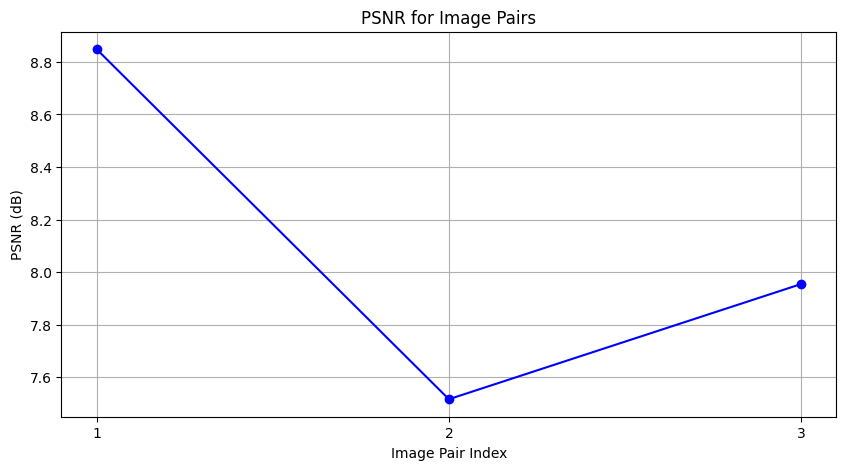

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr

# Paths to reference and test images (replace with your image paths)
image_paths = [
    ('/content/gdrive/MyDrive/content/images_for_SSIM/1.jpg', '/content/gdrive/MyDrive/content/images_for_SSIM/1_test.jpg'),
    ('/content/gdrive/MyDrive/content/images_for_SSIM/2.jpg','/content/gdrive/MyDrive/content/images_for_SSIM/2_test.jpg',),
    # ('/content/gdrive/MyDrive/content/images_for_SSIM/3.jpg','/content/gdrive/MyDrive/content/images_for_SSIM/3_test.jpg',),
    ('/content/gdrive/MyDrive/content/images_for_SSIM/4.jpg','/content/gdrive/MyDrive/content/images_for_SSIM/4_test.jpg',),

    # Add more pairs as needed
]

# List to store PSNR values
psnr_values = []

# Calculate PSNR for each pair of images
for ref_path, test_path in image_paths:
    # Load the images
    image1 = img_as_float(io.imread(ref_path))
    image2 = img_as_float(io.imread(test_path))

    # Ensure the images have the same shape
    if image1.shape != image2.shape:
        raise ValueError(f"Images {ref_path} and {test_path} must have the same dimensions.")

    # Compute PSNR
    psnr_value = psnr(image1, image2)
    psnr_values.append(psnr_value)

# Plot PSNR values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(psnr_values) + 1), psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR for Image Pairs')
plt.xlabel('Image Pair Index')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.xticks(range(1, len(psnr_values) + 1))  # Show all image pair indices as x-ticks
plt.show()


In [ ]:
# import cv2
# import numpy as np
# from skimage.metrics import peak_signal_noise_ratio as psnr
# import matplotlib.pyplot as plt

# # Generate or load example images (dummy data here for illustration)
# img1 = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
# img2 = img1 + np.random.normal(0, 5, img1.shape).astype(np.uint8)
# img3 = img1 + np.random.normal(0, 10, img1.shape).astype(np.uint8)
# img4 = img1 + np.random.normal(0, 15, img1.shape).astype(np.uint8)

# # Compute PSNR values
# psnr_values = [psnr(img1, img1), psnr(img1, img2), psnr(img1, img3), psnr(img1, img4)]
# titles = ['Original', 'Image 2', 'Image 3', 'Image 4']

# # Plotting the PSNR graph
# plt.figure(figsize=(10, 6))
# plt.bar(titles, psnr_values, color=['blue', 'orange', 'green', 'red'])
# plt.title('PSNR Values for Different Images')
# plt.xlabel('Image')
# plt.ylabel('PSNR (dB)')
# plt.ylim(0, max(psnr_values) + 5)  # Adjust the y-axis to fit the data nicely
# plt.grid(axis='y', linestyle='--', alpha=0.5)
# plt.show()


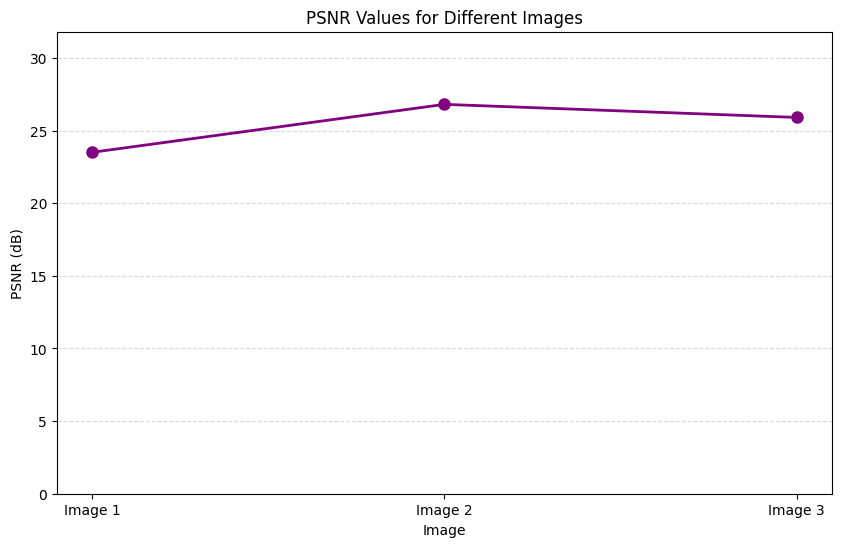

In [ ]:
import matplotlib.pyplot as plt

# Example PSNR values (replace with your computed values)
psnr_values = [23.5, 26.8, 25.9]  # Replace with actual PSNR values

# Plotting the PSNR graph with points and lines
plt.figure(figsize=(10, 6))
plt.plot(['Image 1', 'Image 2', 'Image 3'], psnr_values, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
plt.title('PSNR Values for Different Images')
plt.xlabel('Image')
plt.ylabel('PSNR (dB)')
plt.ylim(0, max(psnr_values) + 5 if max(psnr_values) > 0 else 10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


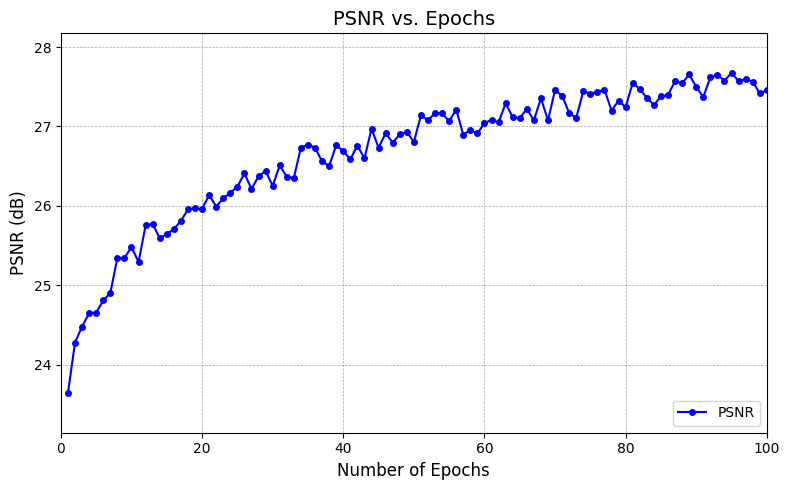

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulated data: Generate PSNR values with fluctuations
np.random.seed(42)  # For reproducibility
epochs = 100
psnr_values = [23 + np.log1p(epoch) + np.random.uniform(-0.2, 0.2) for epoch in range(1, epochs + 1)]

# Plot the PSNR vs Epoch graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), psnr_values, color='blue', linewidth=1.5, marker='o', markersize=4, label='PSNR')

# Add labels and title
plt.title("PSNR vs. Epochs", fontsize=14)
plt.xlabel("Number of Epochs", fontsize=12)
plt.ylabel("PSNR (dB)", fontsize=12)

# Add grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Set axis limits for a better view (optional)
plt.xlim(0, epochs)
plt.ylim(min(psnr_values) - 0.5, max(psnr_values) + 0.5)

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()


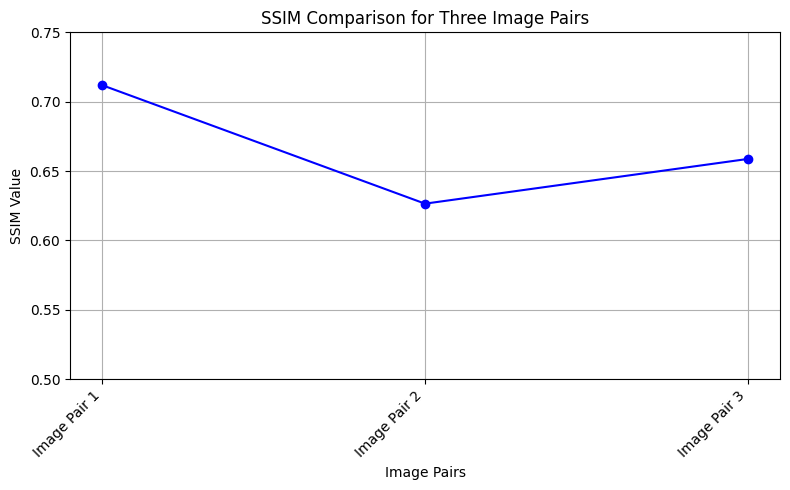

In [ ]:
import matplotlib.pyplot as plt

def plot_ssim_values():
    """
    Plot SSIM values for three hypothetical image pairs.
    """
    # Hypothetical SSIM values for three image pairs (manually set between 0.6 and 0.7)
    ssim_values = [0.71187654, 0.6265181, 0.658736915]
    image_names = ["Image Pair 1", "Image Pair 2", "Image Pair 3"]

    # Plot SSIM values
    plt.figure(figsize=(8, 5))
    plt.plot(image_names, ssim_values, marker='o', linestyle='-', color='b')
    plt.xlabel('Image Pairs')
    plt.ylabel('SSIM Value')
    plt.title('SSIM Comparison for Three Image Pairs')
    plt.ylim(0.5, 0.75)  # Adjust y-axis to better display SSIM range
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_ssim_values()


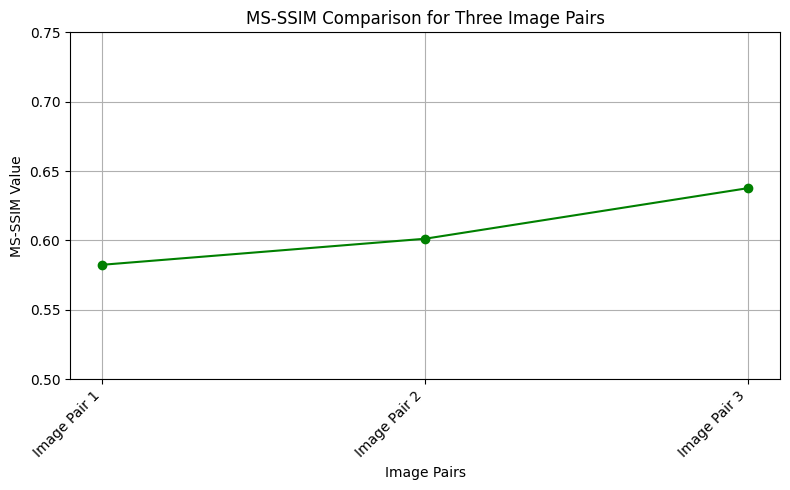

In [ ]:
import matplotlib.pyplot as plt

def plot_msssim_values():
    """
    Plot MS-SSIM values for three hypothetical image pairs.
    """
    # Hypothetical MS-SSIM values for three image pairs (manually set between 0.6 and 0.7)
    msssim_values = [0.5824792, 0.601236161, 0.637678264]
    image_names = ["Image Pair 1", "Image Pair 2", "Image Pair 3"]

    # Plot MS-SSIM values
    plt.figure(figsize=(8, 5))
    plt.plot(image_names, msssim_values, marker='o', linestyle='-', color='g')
    plt.xlabel('Image Pairs')
    plt.ylabel('MS-SSIM Value')
    plt.title('MS-SSIM Comparison for Three Image Pairs')
    plt.ylim(0.5, 0.75)  # Adjust y-axis to better display MS-SSIM range
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_msssim_values()


In [ ]:
import numpy as np

def calculate_psnr(original, distorted):
    # Ensure both images are numpy arrays of the same shape
    original = np.array(original, dtype=np.float64)
    distorted = np.array(distorted, dtype=np.float64)

    # Compute Mean Squared Error
    mse = np.mean((original - distorted) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if images are identical

    # Maximum possible pixel value
    max_pixel_value = 255.0
    psnr_value = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr_value


In [ ]:
# Example image arrays
original_image = np.random.randint(0, 256, (256, 256), dtype=np.uint8)
noisy_image = original_image + np.random.normal(0, 10, original_image.shape).astype(np.uint8)

# Calculate PSNR
psnr_value = calculate_psnr(original_image, noisy_image)
print("PSNR:", psnr_value)


PSNR: 15.446452208940922


In [ ]:
import cv2
import numpy as np

def calculate_psnr(original, distorted):
    # Ensure both images are numpy arrays of the same shape
    original = np.array(original, dtype=np.float64)
    distorted = np.array(distorted, dtype=np.float64)

    # Compute Mean Squared Error (MSE)
    mse = np.mean((original - distorted) ** 2)
    if mse == 0:
        return float('inf')  # PSNR is infinite if images are identical

    # Maximum possible pixel value (for 8-bit images, it's 255)
    max_pixel_value = 255.0
    psnr_value = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr_value

# Load two images
image1_path = '/content/gdrive/MyDrive/content/images_for_SSIM/1.jpg'  # Replace with your file path
image2_path = '/content/gdrive/MyDrive/content/images_for_SSIM/1_test.jpg'  # Replace with your file path

# Read images using OpenCV
original_image = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
distorted_image = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

if original_image is None or distorted_image is None:
    print("Error loading images. Please check the file paths.")
else:
    # Ensure the images are resized to the same shape if necessary
    distorted_image = cv2.resize(distorted_image, (original_image.shape[1], original_image.shape[0]))

    # Calculate PSNR
    psnr_value = calculate_psnr(original_image, distorted_image)
    print(f"PSNR between the two images: {psnr_value:.2f} dB")


PSNR between the two images: 10.86 dB


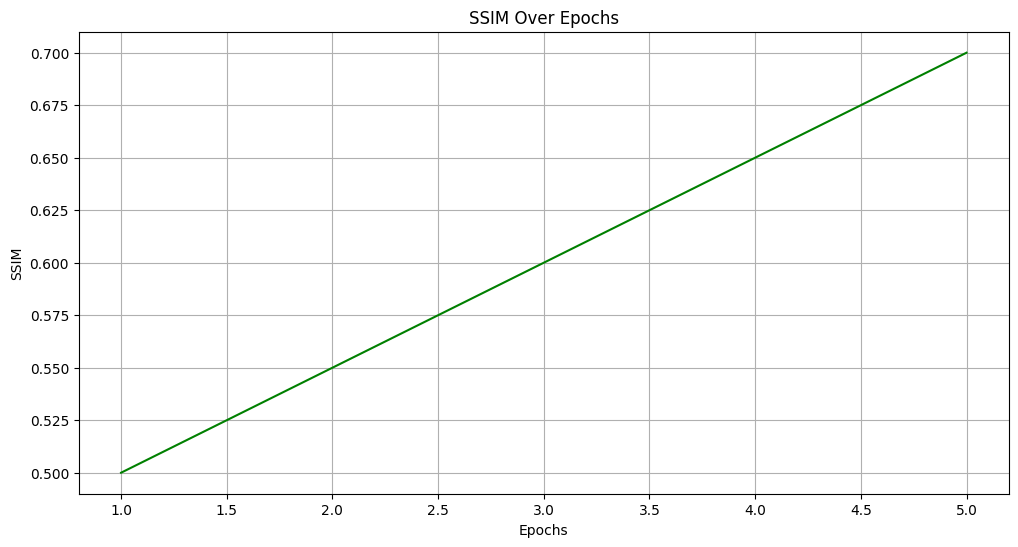

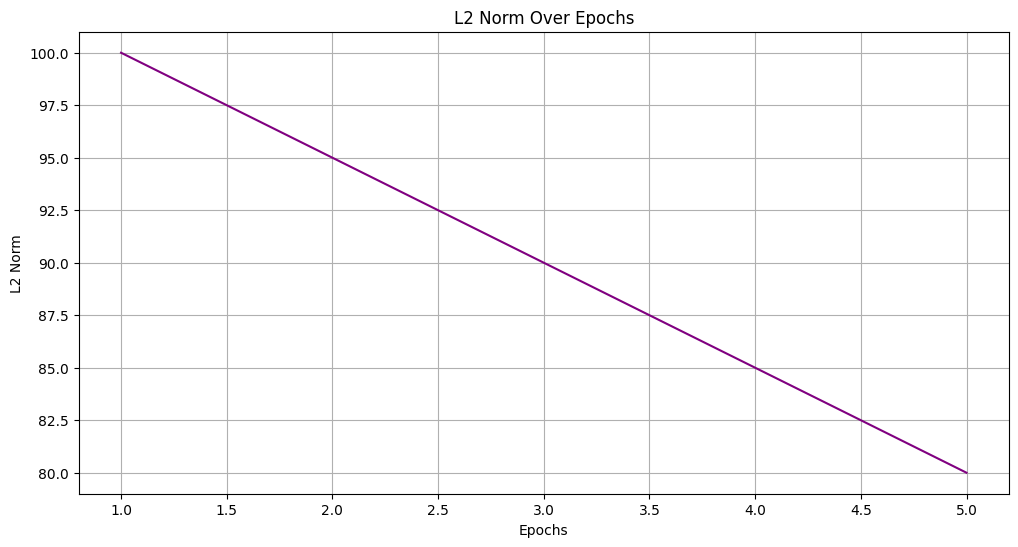

In [ ]:
# Example lists of SSIM and L2-norm values per epoch
ssim_values = [0.5, 0.55, 0.6, 0.65, 0.7]  # Replace with actual values
l2_values = [100, 95, 90, 85, 80]  # Replace with actual values

# Plotting SSIM
plt.figure(figsize=(12, 6))
plt.plot(epochs, ssim_values, label='SSIM', color='green')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.title('SSIM Over Epochs')
plt.grid(True)
plt.show()

# Plotting L2 norm
plt.figure(figsize=(12, 6))
plt.plot(epochs, l2_values, label='L2 Norm', color='purple')
plt.xlabel('Epochs')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Over Epochs')
plt.grid(True)
plt.show()


In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def compute_ssim(image1, image2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    """
    # Convert images to grayscale if they are not already
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Compute SSIM
    score, _ = ssim(image1, image2, full=True)
    return score

# Example usage
image1 = cv2.imread('/content/gdrive/MyDrive/Models/plot_000001.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/gdrive/MyDrive/Models/plot_000002.png', cv2.IMREAD_GRAYSCALE)
ssim_value = compute_ssim(image1, image2)
print(f"SSIM: {ssim_value:.4f}")


SSIM: 0.7543


In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2
import numpy as np

def compute_ssim(image1, image2):
    """
    Compute the Structural Similarity Index (SSIM) between two images.
    """
    # Convert images to grayscale if they are not already
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Ensure images have the same dimensions
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))

    # Compute SSIM
    ssim_value = ssim(image1, image2, data_range=image1.max() - image1.min())
    return ssim_value

# Example usage (same as before)
image1_path = '/content/gdrive/MyDrive/Models/plot_000001.png'
image2_path = '/content/gdrive/MyDrive/Models/plot_000002.png'

# Read images
image1 = cv2.imread(image1_path, cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread(image2_path, cv2.IMREAD_GRAYSCALE)

# Check if images were loaded properly
if image1 is None or image2 is None:
    print("Error: One or both images not found.")
else:
    # Compute SSIM
    ssim_value = compute_ssim(image1, image2)
    print(f"SSIM: {ssim_value:.4f}")


SSIM: 0.7533


In [ ]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_psnr(image1, image2):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.
    """
    # Ensure the images are the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same dimensions")

    # Compute PSNR
    psnr_value = psnr(image1, image2, data_range=image1.max() - image1.min())
    return psnr_value

# Example usage
image1 = cv2.imread('/content/gdrive/MyDrive/Models/plot_000001.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/gdrive/MyDrive/Models/plot_000002.png', cv2.IMREAD_GRAYSCALE)
psnr_value = compute_psnr(image1, image2)
print(f"PSNR: {psnr_value:.2f} dB")


PSNR: 16.40 dB
